<a name="0"></a> 

# Anomaly Detection 

The data consists of a one-dimensional temperature sensory signal for an internal component of a large industrial machine. The first anomaly is a planned shut down and takes place early in the signal in December. The second anomaly happens later in the signal in early February and is subtle in comparison but leads into a third anomaly which is considered a catastrophic failure. 

* [Link to Data](https://github.com/numenta/NAB/blob/master/data/realKnownCause/machine_temperature_system_failure.csv) 

---

## Models 

* **Hidden Markov Model with Normal Emission Probabilities** 
* **Masked Autoencoder for Density Estimation** 

---

## Notebook Outline 

* [1. Load and Plot Signal](#1) 
* [2. Hidden Markov Model with Normal Emissions](#2) 
* [3. Masked Autoencoder for Density Estimation ](#3) 
* [4. Summary and Conclusion](#4) 

---



In [1]:
import os 
os.chdir('../') 

import numpy as np 
from dspML import data, plot, utils 
from dspML.preprocessing import sequence 
from dspML.models.sequence import made, NormalHMM as HMM 
from dspML.evaluation import Detection 

<a name="1"></a> 

# 1. Load and Plot Signal 

[Outline](#0) 

----

Load the signal and plot it with a horizontal threshold line for anomalies at 47 degrees. 

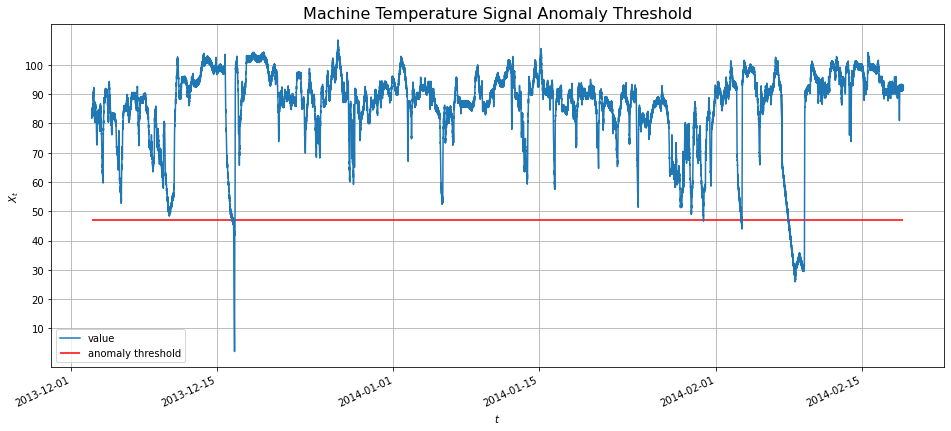

In [2]:
# load signal 
signal = data.machine_temperature() 

# plot full signal 
plot.signal_pd(
    signal, 
    title='Machine Temperature Signal Anomaly Threshold', 
    figsize=(16, 7), 
    rotation=25, 
    yticks=np.arange(10, 110, 10), 
    thresh=47
) 

---

## Split Signal and Plot

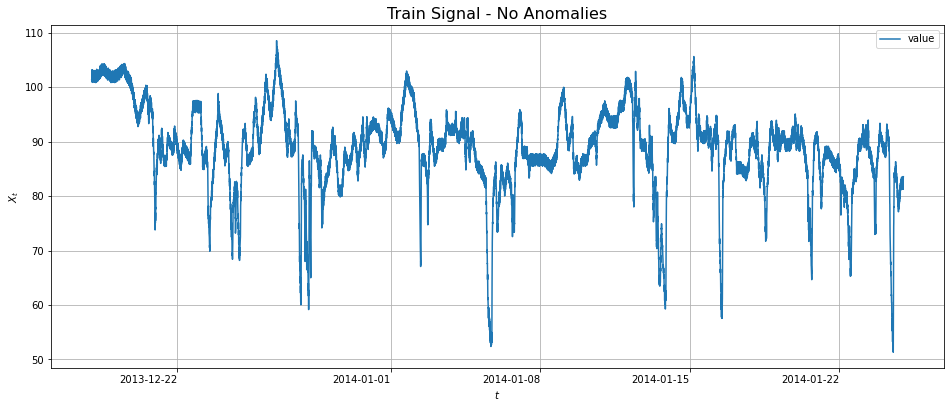

In [3]:
# train signal 
signal_train = signal.loc['2013-12-18 00:00:00':'2014-01-24 23:55:00'] 

# plot train signal 
plot.signal_pd(
    signal_train, title='Train Signal - No Anomalies', figsize=(16, 7)
) 

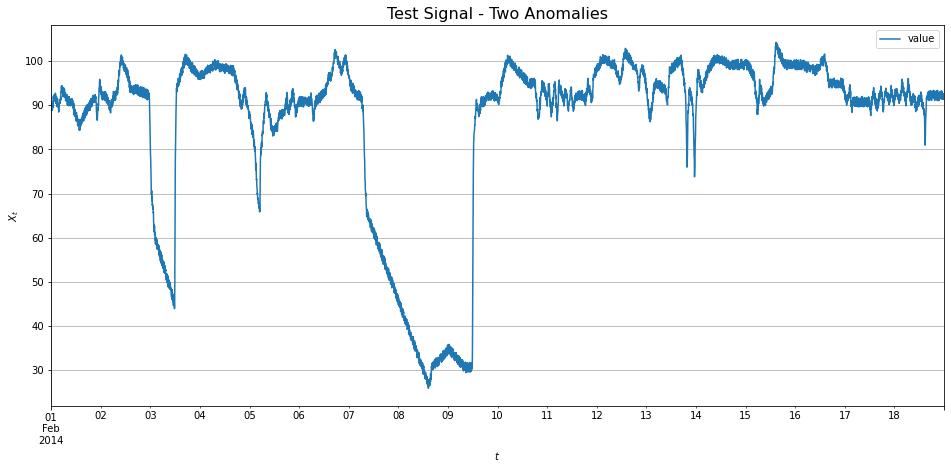

In [4]:
# test signal 
signal_test = signal.loc['2014-02-01 00:00:00':] 

# plot test signal 
plot.signal_pd(
    signal_test, title='Test Signal - Two Anomalies', figsize=(16, 7)
) 

---

## Extract and Plot True Anomalies 

An anomaly for this signal will be defined as time steps where the temperature drops below 47 degrees. 

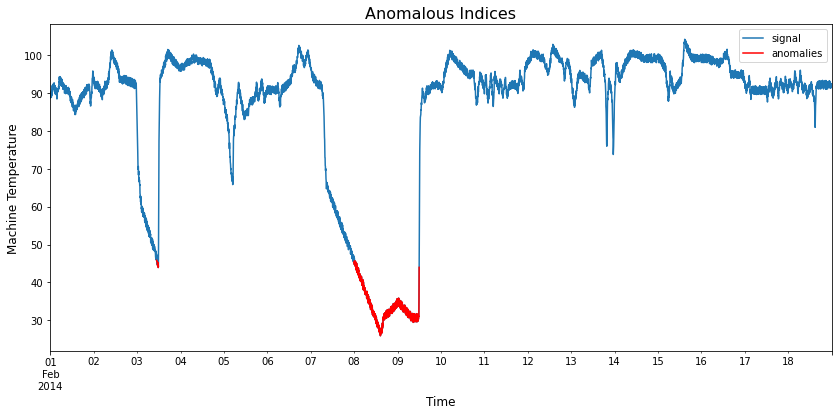

In [5]:
# extract true anomalies 
anoms_true = utils.extract_anomalous_indices(signal_test, thresh=47) 

# plot true anomalies 
plot.anomalies(signal_test, anoms_true) 

---

<a name="2"></a> 

# 2. Hidden Markov Model with Normal Emissions

[Outline](#0) | [Section 3 Outline](#3) | [Summary and Conclusion](#4) 

---

## Section Outline 

* [Fit Model](#2-1) 
* [Posterior Inference](#2-2) 
* [Detect Anomalies](#2-3)
* [Plot Detected Anomalies](#2-4)

---

## Define Model 

The Hidden Markov model will be defined to have 3 hidden states following a uniform distribution and the transition probability matrix is defined to have a 0.001 probability of changing states. The observation distribution is normal where the mean is a trainable variable and a standard deviation of 5. The prior distribution is a normal distribution where the mean is the overall mean of the February portion of the signal and standard deviation equal to 10. 

In [6]:
# convert to numpy and reduce dimension 
x = sequence.reduce_dims(sequence.to_numpy(signal_test)) 

# define Hidden Markov Model and prior 
n_states = 3 
p_change = 0.001 
hmm, prior = HMM.NormalHMM(x, n_states, p_change) 

---

<a name="2-1"></a> 

## Fit Model 

[Section Outline](#2) 

The model is fit with gradient descent using the Adam optimizer to compute the maximum a posteriori. The loss function implemented is negative log probability loss and the fitting process runs for 501 epochs. 

In [7]:
# fit trainable mean parameter 
means = HMM.fit(hmm, prior, x) 

Epoch 0: log prob = -50406.05078125 | means = [86.152 86.585 86.712]
Epoch 20: log prob = -45524.41015625 | means = [84.158 88.65  88.671]
Epoch 40: log prob = -41279.71484375 | means = [82.197 90.939 89.776]
Epoch 60: log prob = -37952.42578125 | means = [80.288 93.164 89.945]
Epoch 80: log prob = -35425.59765625 | means = [78.43  94.716 90.012]
Epoch 100: log prob = -33284.18359375 | means = [76.626 95.864 90.19 ]
Epoch 120: log prob = -31424.859375 | means = [74.876 96.688 90.403]
Epoch 140: log prob = -29776.037109375 | means = [73.18  97.263 90.601]
Epoch 160: log prob = -28293.45703125 | means = [71.539 97.677 90.776]
Epoch 180: log prob = -26957.6953125 | means = [69.951 97.955 90.9  ]
Epoch 200: log prob = -25750.333984375 | means = [68.418 98.124 90.969]
Epoch 220: log prob = -24656.857421875 | means = [66.938 98.22  90.998]
Epoch 240: log prob = -23665.884765625 | means = [65.51  98.273 90.997]
Epoch 260: log prob = -22771.322265625 | means = [64.136 98.3   90.982]
Epoch 280:

---

<a name="2-2"></a> 

## Posterior Inference 

[Section Outline](#2) 

We can extract the posterior marginal distribution from the HMM and use it to find the posterior probabilities along with the most likely mean parameters and states of the system. We will use the marginal posterior distributions to obtain the most likely means and states of the system and visualize it to determine which state and mean is likely to be the anomolous indices of the signal. 

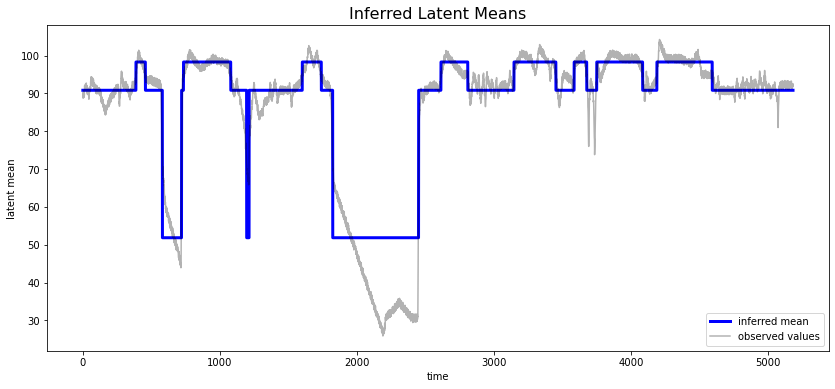

In [8]:
# posterior distribution and most likely states and means 
posterior_dists, ml_means, ml_states = HMM.posterior_inference(hmm, x) 

# plot inferred latent means 
HMM.plot_inferred_means(x, means, ml_means, ml_states) 

---

<a name="2-3"></a> 

## Detect Anomalies 

[Section Outline](#2) 

Since the latent state with the smallest inferred mean is very far from the rest of the signal we will let the observations in this state be anomalies. 

In [9]:
# detect anomalies 
anoms_hmm = HMM.anomalous_means(ml_means) 

# performance metrics 
metrics = Detection(anoms_true, anoms_hmm) 
metrics.precision() 
metrics.recall() 
metrics.f1_score() 

Precision: 0.7834394904458599
Recall: 0.9641274530491665
F1-Score = 0.7236


---

<a name="2-4"></a> 

## Plot Detected Anomalies 

[Section Outline](#2) | [Summary and Conclusion](#4) 

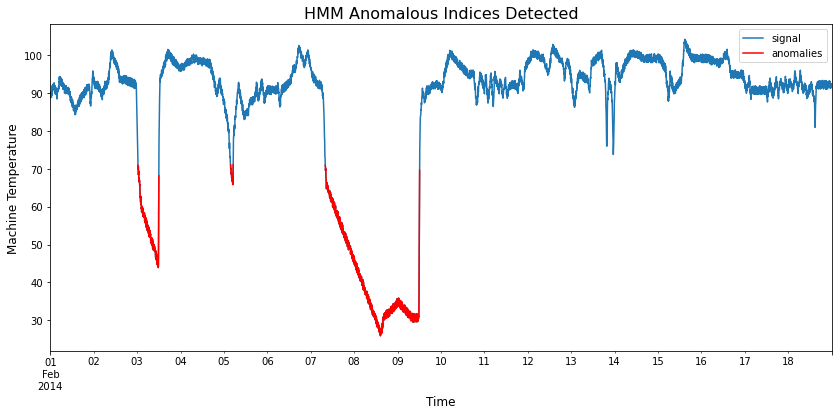

In [10]:
# plot signal with anomalies flagged 
plot.anomalies(
    signal_test, anoms_hmm, title='HMM Anomalous Indices Detected'
) 

DISCUSS RESULTS. 

---

<a name="3"></a> 

# 3. Masked Autoencoder for Density Estimation 

[Outline](#0) | [Section 2 Outline](#2) | [Summary and Conclusion](#4) 

---

## Section Outline 

* [Define Model](#3-1)
* [Fit Model](#3-2) 
* [Sample from Estimated Distribution](#3-3) 
* [Test Signal Probabilities](#3-4) 
* [Detect Anomalies](#3-5) 
* [Plot Detected Anomalies](#3-6) 

---

## Preprocess Train and Test Signals 

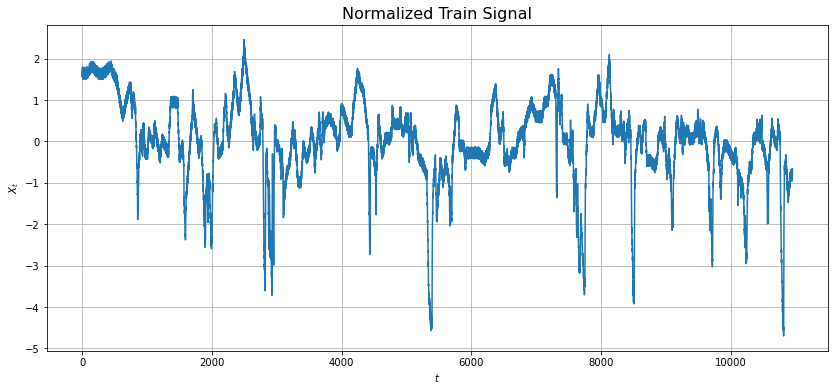

In [11]:
# convert to numpy array 
x_train = sequence.to_numpy(signal_train) 

# normalize signal 
x_train, norm = sequence.normalize_train(x_train) 

# plot signal 
plot.signal_np(x_train, title='Normalized Train Signal') 

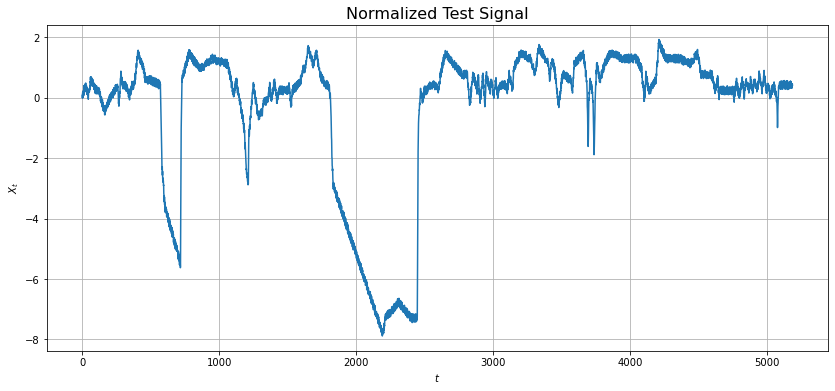

In [12]:
# convert to numpy array 
x_test = sequence.to_numpy(signal_test) 

# normalize signal 
x_test = sequence.normalize_test(x_test, norm) 

# plot signal 
plot.signal_np(x_test, title='Normalized Test Signal') 

---

<a name="3-1"></a> 

## Define Model 

[Section Outline](#3) 

The MADE model consists of a standard normal distribution function that will be bijectively transformed to yield a probability distribution estimate of the data. The model is an Autoregressive Network that estimates 2 parameters corresponding to location and log scale. The autoregressive network is implemented with a masked autoregressive flow such that the autoregressive property of the network is met in its inverse. 

In [13]:
# define model 
model, dist = made.MADE(params=2) 
model.summary() 

Model: "Masked_Autoencoder_Density_Estimation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
autoregressive_network (Autoreg (None, 1, 2)         42          input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_unstack_1 (TensorFl [(None, 1), (None, 1 0           autoregressive_network[1][0]     
__________________________________________________________________________________________________
tf_op_layer_Sub_1 (TensorFlowOp [(None, 1)]          0        

---

<a name="3-2"></a> 

## Fit Model 

[Section Outline](#3) 

The model is fit to the controlled portion of the signal with no anomalies since that is generally how the system temperatures should fluctuate. The February portion of the signal will be used as test data since there are a few anomalies present in that ending portion of the full signal. The model is fit for 1 epoch since MADE using MAF is capable of estimating the density function with just one pass through the data. Further, the model sees data in batches of size 32 and the response variable, $y$, consists of an array of zeros of the same length of the train signal. 

In [14]:
# fit model 
made.fit(model, x_train, epochs=1) 

342/342 [==============================] - 0s 500us/step - loss: 1.4187


---

<a name="3-3"></a> 

## Sample from Estimated Distribution 

[Section Outline](#3) 

Note that MADE implementing MAF needs to see the data more to produce a random sample of the estimated distribution. 

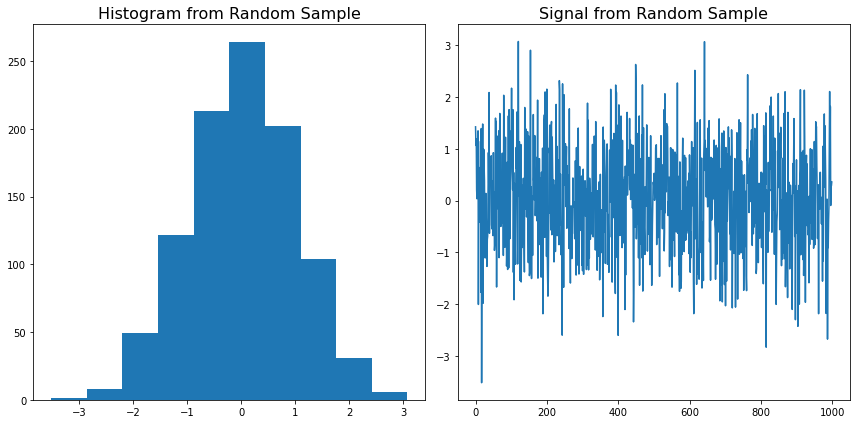

In [15]:
# plot random sample 
made.plot_random_sample(dist, n=1000) 

---

<a name="3-4"></a> 

## Test Signal Probabilities 

[Section Outline](#3) 

Now that our initial distribution is transformed to fit the train signal, we can compute the probabilities of the test signal observations. 

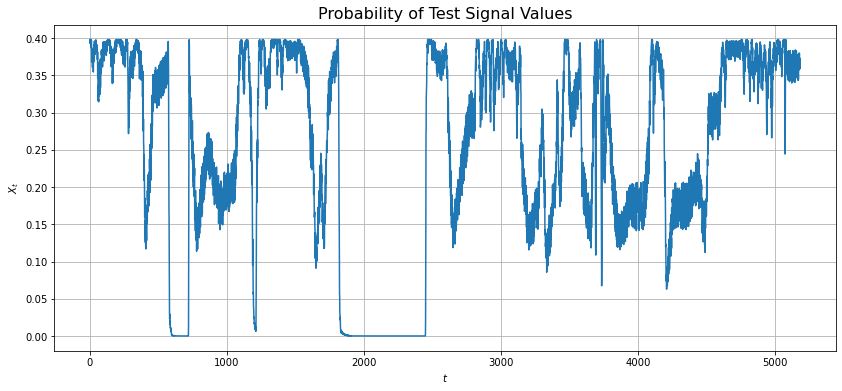

In [16]:
# test probabilities 
px = dist.prob(x_test).numpy() 

# plot test observation probabilities 
plot.signal_np(px, title='Probability of Test Signal Values') 

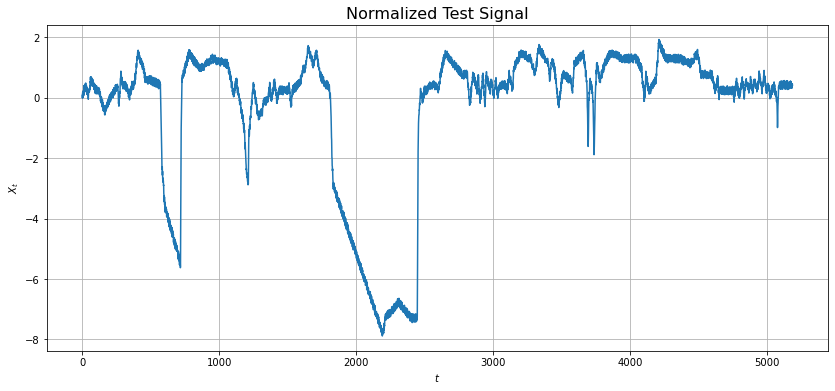

In [17]:
# plot test observations for comparison 
plot.signal_np(x_test, title='Normalized Test Signal') 

The plot of the probabilities suggests that there are a handful of observations that have a probability very close to 0. This means that there are likely anomalous portions of the signal considering that the signal comes from the same component of the same machine. 

---

<a name="3-5"></a> 

## Detect Anomalies 

[Section Outline](#3) 

Using the idea of a statistical hypothesis test, we will say that the observations do not belong to the systems distribution if their probabilities are less than 0.05. This will act as a probabilistic threshold to detect anomalies in the system. 

In [18]:
# let anomalous observations have p(x) < 0.05 
anoms_made = px < 0.05  

# performance metrics 
metrics = Detection(anoms_true, anoms_made) 
metrics.precision() 
metrics.recall() 
metrics.f1_score() 

Precision: 0.7827191867852605
Recall: 0.9639164380671028
F1-Score = 0.7224


---

<a name="3-6"></a> 

## Plot Detected Anomalies 

[Section Outline](#3) | [Summary and Conclusion](#4) 



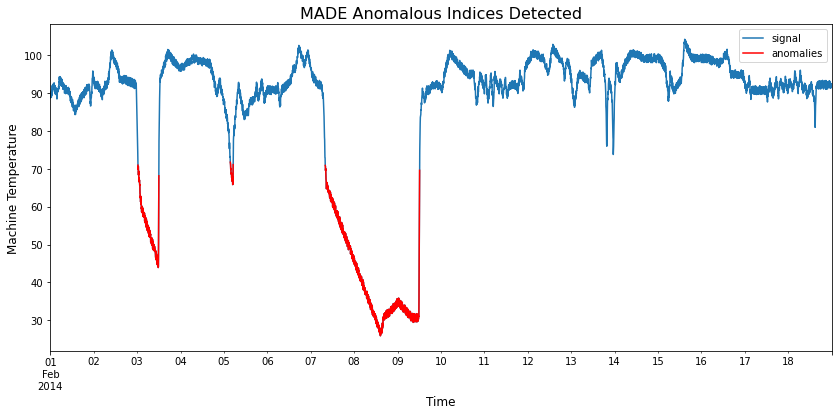

In [19]:
# plot signal with anomalies flagged 
plot.anomalies(
    signal_test, anoms_made, title='MADE Anomalous Indices Detected'
) 



---

<a name="4"></a> 

# 4. Summary and Conclusion 

[Outline](#0) | [Section 2 Outline](#2) | [Section 3 Outline](#3) 

---

## Section Contents 

* [Performance Metrics](#4-1) 
* [Conclusion](#4-2) 

---

## Detected Anomaly Plots 

Before we consider the performance metrics, observe the plots of the true anomalies defined as temperatures that fall below 47 degrees and the predicted anomalies for the HMM and MADE. 


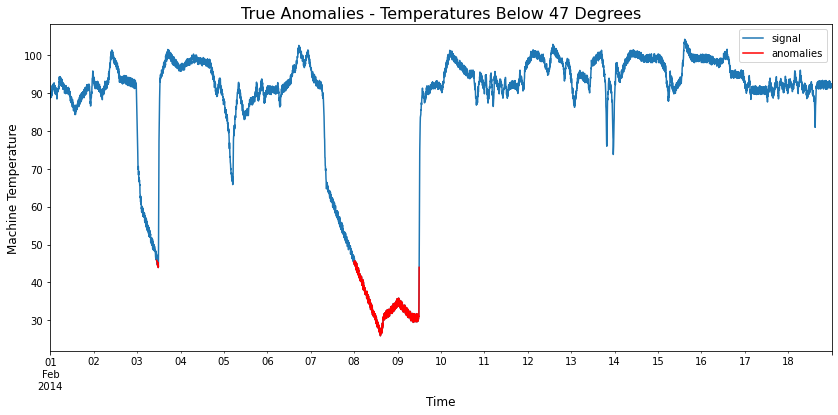

In [20]:
# true anomalies 
plot.anomalies(
    signal_test, anoms_true, title='True Anomalies - Temperatures Below 47 Degrees'
) 

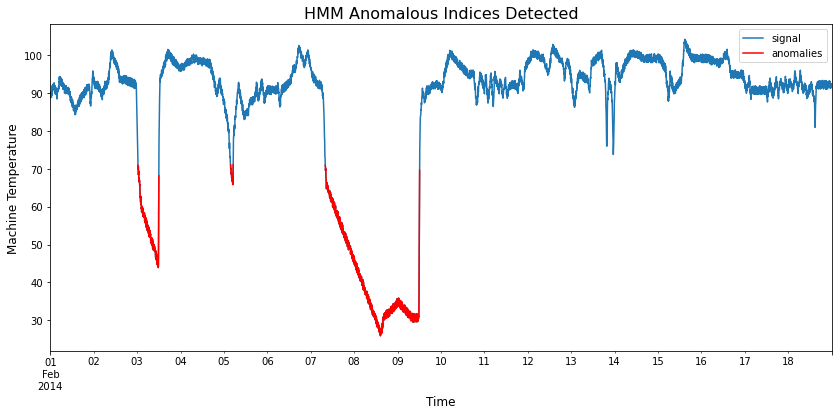

In [21]:
# HMM predicted anomalies 
plot.anomalies(
    signal_test, anoms_hmm, title='HMM Anomalous Indices Detected'
) 

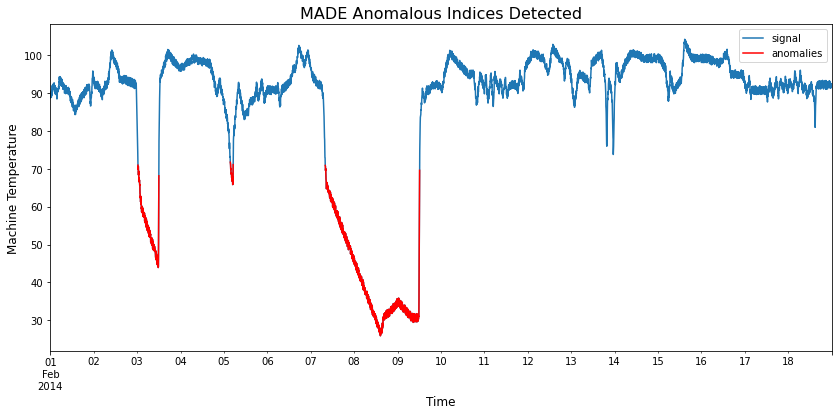

In [22]:
# MADE predicted anomalies 
plot.anomalies(
    signal_test, anoms_made, title='MADE Anomalous Indices Detected'
) 

<a name="4-1"></a> 

## Performance Metrics 

The table below summarizes the performance metrics considered for detecting anomalies. Links to the sections they come from in the notebook are displayed as well. 

[HMM Performance Metrics](#2-3) | [MADE Performance Metrics](#3-5) 

| Model | Precision | Recall | $F_1$ Score | 
| :---: | :---:     | :---:  | :---:       | 
| HMM   | 0.7845    | 0.9644 | 0.7253      | 
| MADE  | 0.7827    | 0.9639 | 0.7224      | 




---

<a name="4-2"></a> 

## Conclusion 

One notable difference is that the Hidden Markov model does not need to be fit to a stable part of the signal to detect anomalies, but it can be tricky since the number of states is user defined. One way around that is to use Bayesian model selection, but 3 states were selected in this case so the states and their latent means wouldn't vary as much with the number of observations in them. With more states selected, there would be a lot more transitions at smaller intervals which could make it difficult to select the anomalous state. 

MADE detected anomalies in a very different approach in comparison. It is a neural network that was fit to a stable portion of the signal that denotes how it should behave. Other types of autoencoders can also be implemented to anomaly detection as well but the approach is very different at the same time. Another application of autoencoders do not require density estimation, but they essentially learn a latent representation of smaller sequences and determine a reconstruction threshold to detect anomalies. 

Observing the plots of the anomalies, both models raised false alarms for February 5th but they both captured the true anomlies as well. While this is an error, a false positive detection is more beneficial than a false negative because if the anomalies are missed the machine could completely fail. 

These models complete this task in very different manners but the results are almost identical. The $F_1$-Score for HMM is just around 0.003 larger than the MADE $F_1$-Score. Precision and recall were included as well in case we want to consider if the $F_1$-Scores were computed similarly or completely different. Ultimately, both models captured the anomalies present in the signal which means they would have prevented the catastrophic failure that happened around February 7-10. 

---

[Outline](#0) | [Hidden Markov Model](#2) | [Masked Autoencoder for Density Estimation](#3) 